In [1]:
# standard python utilities
import os
from os.path import exists, join, dirname, basename
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm



In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 

import flopy.utils.binaryfile as bf


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'
# permeameter analysis
# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning' # no conditioning data

# tprogs_id = 'north_shifted_stream_distance_analysis'

# connec3d analysis
tprogs_id = '_no_cond_c3d' # no conditioning data



data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'
chan_dir = box_dir+'channel_data/'


In [4]:
# ext_dir = 'F:/WRDAPP'
# c_dir = 'C:/WRDAPP'

# if os.path.exists(ext_dir):
#     loadpth = ext_dir 
# elif os.path.exists(c_dir):
#     loadpth = c_dir 
    
# loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
# # model_ws = loadpth+'Permeameter_for_velocity' + tprogs_id
# model_ws = loadpth+'Permeameter_for_velocity' 

# load_only = ['DIS','OC']
# name = 'MF.nam'
# # name = 'MF_child.nam'
# m = flopy.modflow.Modflow.load(name, model_ws=model_ws, load_only = load_only,
#                                 exe_name='mf2005', version='mf2005')


In [5]:
import h5py
f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

In [6]:
setbacks = np.arange(0,3400,200)

In [7]:
def prep_hf_area(hf_tot_df, ax=None):
    '''  prepare data/plot - transpose, hectares, xticks'''
    hf_tot_df = hf_tot_df.transpose()
    # convert to hectares from m2
    hf_tot_df = hf_tot_df.multiply(1E-4)
    hf_tot_df.index = hf_tot_df.index.astype(int)
    if ax != None:
        # so that xticks align with actual locations
#         ax.set_xticks(hf_tot_df.index[::2])
        ax.set_xticks(hf_tot_df.index)
#         ax.set_xticks(hf_tot_df.index, hf_tot_df.index.astype(str), rotation=45, rotation_mode='anchor', ha='right')
        ax.set_xticks([], minor=True)
        ax.set_xlabel('Setback Distance (m)')
    return(hf_tot_df)

In [8]:

def plt_hf_cum_area(hf_tot_df, percentile, label,ax):
    ''' plot the total High Conuctivity area within each step '''
    # prepare data/plot - transpose, hectares, xticks
    hf_tot_df = prep_hf_area(hf_tot_df, ax)
    hf_max = hf_tot_df.max().max()
    hf_tot_df.plot(color='lightgray',ax=ax, legend=False)
    hf_tot_df.mean(axis=1).plot(legend=False, ax=ax, color='black', label='Realizations Averaged') #colormap='gray',
    ax.set_ylabel('Cumulative Area  (ha)')
#     plt.title(label)
#     ax.set_title(str(percentile)+'th percentile of Flow')
#     plt.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
#     plt.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
#     plt.savefig(fig_dir+'high_flow_cells_by_distance_'+label+'_'+str(percentile)+'.png',dpi=600)
    # plt.legend(ncol = 4, loc = (1.05, 0.05))
    


In [8]:
# percentile = 95
percentile = 6


label='regional'
hf_tot_df = pd.read_csv(data_dir+'surface_highflow_by_distance_'+label+'_'+str(percentile)+'.csv')


In [9]:

label='local'
# # each set of 100 rows is a different location
hf_tot_df_local = pd.read_csv(data_dir+'surface_highflow_by_distance_'+label+'_'+str(percentile)+'.csv')
# # join local and regional datasets
hf_all = pd.concat((hf_tot_df, hf_tot_df_local))
site_order = ['Regional','Lower','Middle','Upper']

# hf_all = hf_tot_df.copy()
# site_order = ['Regional']

# # create clean index for easier referencing
site_realization = np.vstack((np.repeat(site_order,100),
                              np.tile(np.arange(1,101),int(hf_all.shape[0]/100))))
site_realization_index = pd.MultiIndex.from_arrays(site_realization,names=['Site','Realization'])

hf_all = hf_all.set_index(site_realization_index)

# convert from number of cells to area, m^2
hf_all.loc[:] = hf_all.values*200*200
# plot with setback as x and realizations as label
hf_all.columns = pd.to_numeric(hf_all.columns)

In [10]:
def plt_hf_step_area(hf_tot_df, percentile, label,ax):
    ''' plot the High Conuctivity area added by each step '''
    hf_tot_df = prep_hf_area(hf_tot_df, ax)
    hf_diff = hf_tot_df.diff(axis=0)
    hf_diff.iloc[0,:] = hf_tot_df.iloc[0,:]
    hf_max = hf_diff.max().max()
    # use cell numbers for axis
#     hf_diff.index = np.arange(1, len(hf_diff)+1)
    hf_diff.plot(legend=False, ax=ax,
                 color='lightgray', #colormap='gray',
                )
    hf_diff.mean(axis=1).plot(legend=False, ax=ax, color='black', label='Realizations Averaged') 
    stats_lines(hf_diff, ax=ax)

    ax.set_ylabel('Area (ha)')
#     ax.set_title(str(percentile)+'th percentile of Flow')
#     ax.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
#     ax.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
    fig.tight_layout()
#     plt.savefig(fig_dir+'high_flow_cells_diff_by_distance_'+str(percentile)+'.png',dpi=600)
    


In [12]:
setback_area = str_setbacks.sum(axis=(1,2))*200*200

In [13]:
def stats_lines(df, ax):
    """ Dataframe with realization as columns and setbacks as index"""
    # plot quantiles on the line plot
    quart = df.quantile([.25,.75], axis=1)
    quart.transpose().plot(color='tab:blue', ax=ax, legend=False)
    median = df.quantile([.5], axis=1)
    median.transpose().plot(color='tab:green', ax=ax, legend=False)
    # calculate whiskers
    iqr = quart.loc[0.75]-quart.loc[0.25]
    # 1.5 x the whole interquartile range
    whisker = pd.DataFrame(quart.loc[0.75] + iqr*1.5)
    whisker[1] = quart.loc[0.25] - iqr*1.5
    # where whisker is greater than max or min set as max or min
    whisker.loc[whisker[0]>df.max(axis=1), 0] = df.max(axis=1)[whisker[0]>df.max(axis=1)]
    whisker.loc[whisker[1]<df.min(axis=1), 1] = df.min(axis=1)[whisker[1]<df.min(axis=1)]
    whisker.plot(color='black', ax=ax, legend=False)
#     quant = df.quantile([.05,.95], axis=1)
#     quant.transpose().plot(color='black', ax=ax, legend=False, linestyle='--')


In [15]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

stats_elements = [
    Line2D([0], [0],color='grey',label='Individual\nRealization'),
#     Line2D([0], [0],color='black',label='5th/95th', linestyle='--'),
    Line2D([0], [0],color='black',label='1.5x Quartile\nRange'),
    Line2D([0], [0],color='tab:blue',label='25th/75th'),
    Line2D([0], [0],color='tab:green',label='Median'),
]


In [16]:

# hf_scale = hf_all.loc['Regional'].multiply(1/setback_area, axis=1)
# fig,ax=plt.subplots()
# hf_scale.transpose().plot(legend=False, color='lightgray', ax=ax)
# stats_lines(hf_scale.transpose(), ax=ax)
# ax.legend(handles=stats_elements, loc= 'lower right', ncol=2)



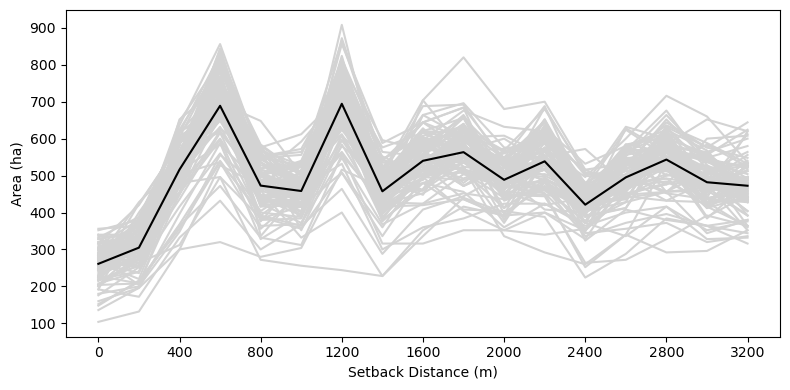

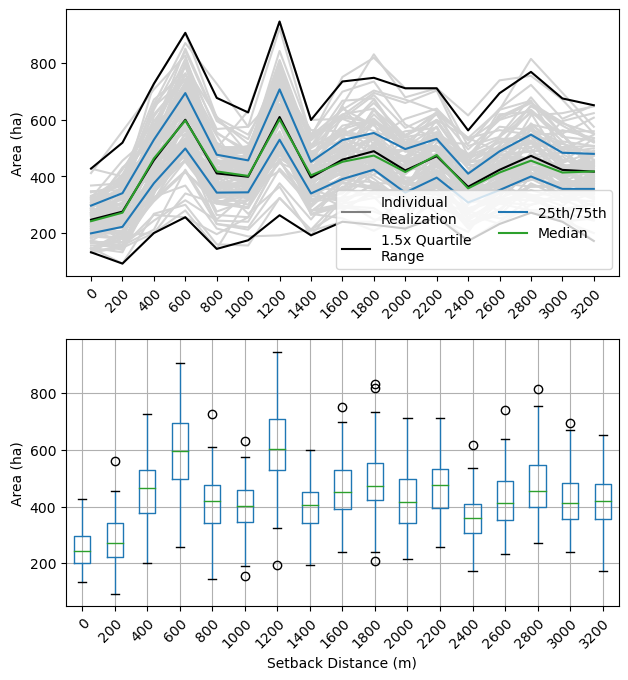

In [17]:
fig,ax=plt.subplots(2,1, figsize=(6.5,6.5))
ax_n = ax[0]
plt_hf_step_area(hf_all.loc['Regional'],percentile, 'regional',ax_n)
plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax_n.legend(handles=stats_elements, loc= 'lower right', ncol=2)
# plt_hf_cum_area(hf_all.loc['Regional'],percentile, 'regional',ax)
# rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax_n.set_xlabel('')
# plt.savefig(fig_dir+'high_flow_cells_diff_by_distance_regional_'+str(percentile)+'.png',dpi=600)

# fig,ax=plt.subplots()
# plt_hf_cum_area(hf_all.loc['Regional'], percentile, 'regional',ax[1])
ax_n = ax[1]
box_df = prep_hf_area(hf_all.loc['Regional'])
box_df_diff = box_df.diff(axis=0)
box_df_diff.iloc[0,:] = box_df.iloc[0,:]

box_df_diff.transpose().boxplot(ax=ax_n)
rot_ticks =  plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax_n.set_ylabel('Area (ha)')
ax_n.set_xlabel('Setback Distance (m)')

Text(0.5, 0, 'Setback Distance (m)')

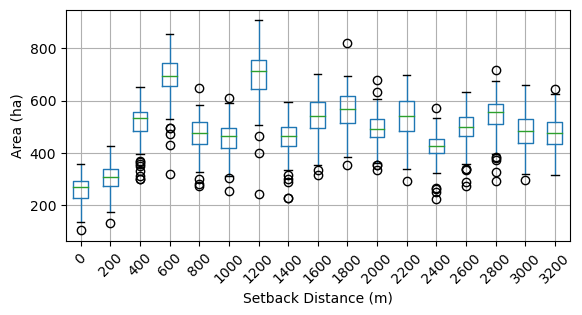

In [53]:
fig,ax=plt.subplots(figsize=(6.5,3))
box_df = prep_hf_area(hf_all.loc['Regional'])
box_df_diff = box_df.diff(axis=0)
box_df_diff.iloc[0,:] = box_df.iloc[0,:]

box_df_diff.transpose().boxplot(ax=ax)
plt.xticks(rotation=45)
plt.ylabel('Area (ha)')
plt.xlabel('Setback Distance (m)')
# boxplt_hf_cum_area(hf_all.loc['Regional'], percentile, 'regional',ax)


In [11]:
# the values are fairly gaussian, slight bias toward low values
# after log transform the bias is more obvious to low values
from scipy.stats import pearsonr, spearmanr, kendalltau
for ns, site in enumerate(site_order):
    print(site)
    hf_long = hf_all.loc[site].melt(ignore_index=False)
    print(pearsonr(hf_long.variable, hf_long.value))
#     print(spearmanr(hf_long.variable, hf_long.value))
# setback distance is well correlated with high conductivity area for all zones
# spearmanr had similar results

Regional
PearsonRResult(statistic=0.9840500717072522, pvalue=0.0)
Lower
PearsonRResult(statistic=0.9609949354916972, pvalue=0.0)
Middle
PearsonRResult(statistic=0.9692333639013891, pvalue=0.0)
Upper
PearsonRResult(statistic=0.9627853291206535, pvalue=0.0)


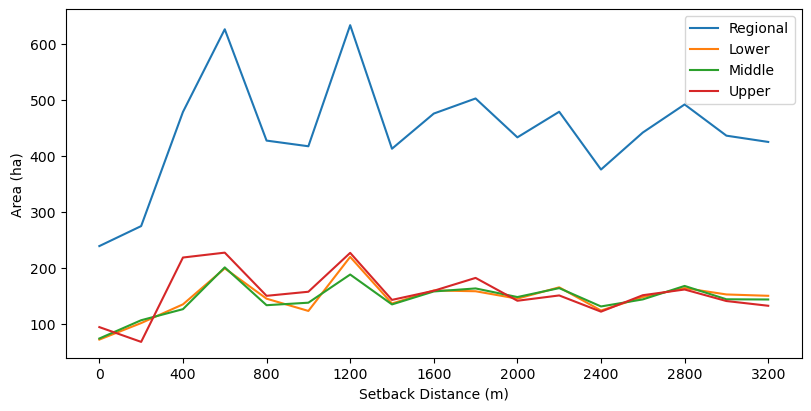

In [35]:
fig,ax=plt.subplots(1,1, figsize=(8,4), layout='constrained', sharex=True)
for ns, site in enumerate(site_order):
    hf_mean = hf_all.loc[site].transpose().multiply(1E-4)
    hf_diff = hf_mean.diff()
    hf_diff.iloc[0,:] = hf_mean.iloc[0]
    hf_diff.mean(axis=1).plot(ax=ax, label=site)
    ax.set_xticks(hf_diff.index[::2])
    ax.set_xlabel('Setback Distance (m)')
    ax.set_ylabel('Area (ha)')
plt.legend()
# fig,ax=plt.subplots(4,1, figsize=(8,8), layout='constrained', sharex=True)

# for ns, site in enumerate(site_order):
#     plt_hf_step_area(hf_all.loc[site],percentile, site,ax[ns])


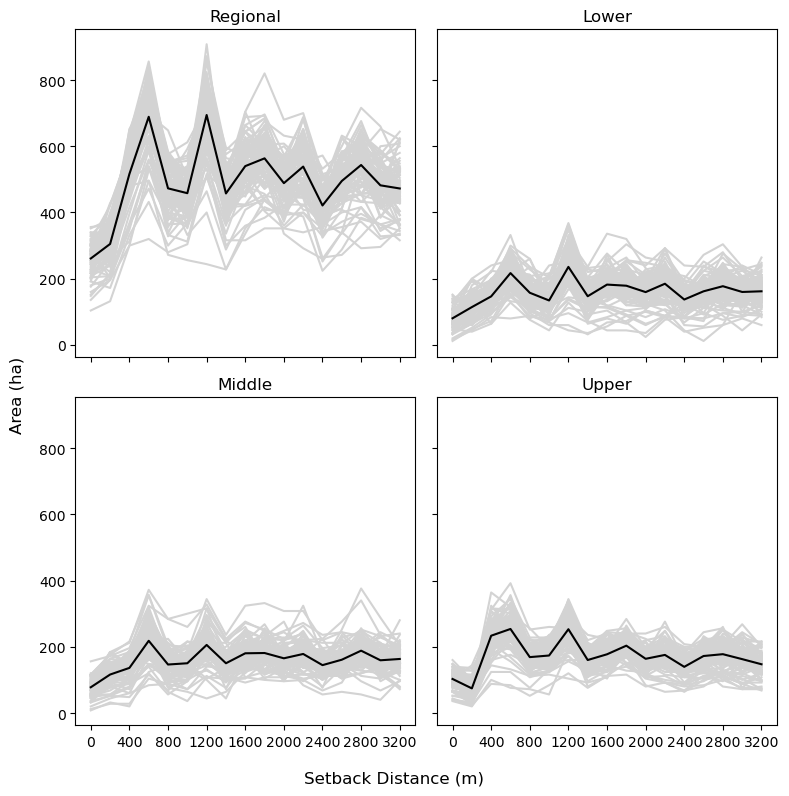

In [60]:

fig,ax=plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))
for nr, region in enumerate(site_order):
    ax_n = ax[int(nr/2),int(nr%2)]
    plt_hf_step_area(hf_all.loc[region],percentile, region,ax_n)

for nr, region in enumerate(site_order):
    ax_n = ax[int(nr/2),int(nr%2)]
    ax_n.set_title(site_order[nr])
    ax_n.set_ylabel('')
    ax_n.set_xlabel('')
# for nf, ft_in in enumerate(ft_plt):
fig.supxlabel('Setback Distance (m)')
    
fig.supylabel('Area (ha)')
fig.tight_layout()

In [27]:
# plot all of these to show initial reaction that on a regional scale all realizations provide high recharge area,
# but local scale these signals are more variable and have more obvious asymptotes
# fig,ax=plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=False)
# for i,n in enumerate(site_order):
#     ax_n = ax[int(i/2), i % 2]
#     df = hf_all.multiply(1E-4).loc[n]
#     df.transpose().plot(legend=False, ax=ax_n, color='lightgray') #colormap='gray',
#     df.transpose().mean(axis=1).plot(legend=False, ax=ax_n, color='black', label='Realizations Averaged') #colormap='gray',

#     # plot min, median and max, median doesn't match up so doesn't plot
#     df[df.mean(axis=1).isin(df.mean(axis=1).quantile([0,0.5,1]).values)].transpose().plot(legend=False, ax=ax_n, color='red')
#     ax_n.set_title(n)
# #     hf_max = df.max().max()
# #     ax_n.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
# #     ax_n.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
# #     plt_hf_cum_area(hf_all.loc[n],percentile,n, ax[i])

# fig.text(-0.02,0.4,'Cumulative Area of High Flow Cells (hectares)',rotation=90, fontdict={'size':18}) 
# fig.text(0.4,-0.03,'Setback distance (m)',  fontdict={'size':18})

# #($m^2$)
# fig.tight_layout()
# plt.savefig(fig_dir+'all_sites_high_flow_cells_diff_by_distance_'+str(percentile)+'.png',dpi=600)

# plt_hf_cum_area(hf_all.loc['Regional'],percentile, 'regional')
# plt_hf_cum_area(hf_all.loc['Blodgett'], percentile, 'local')
# plt_hf_cum_area(hf_all.loc['Mahon'], percentile, 'local')
# plt_hf_cum_area(hf_all.loc['Oneto-Denier'], percentile, 'local')

Plot overlay of high flow cells to see where TPROGs might be heavily identifying recharge spots.

In [134]:
# flow_percentile=95
hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, 100, 230))

In [14]:
def plt_hf_stddev(hf_tot_df, percentile, label):
    ''' percentiles available are 87, 95 and 99th '''
    hf_tot_df = hf_tot_df.transpose()*200*200
    hf_tot_df.index = hf_tot_df.index.astype(int)
    # calculate variance in recharge area between realizations
    stddev = hf_tot_df.std(axis=1)
    stddev.plot(colormap='gray',ax=ax, legend=False, label=label)

    plt.xlabel('Setback Distance (m)')
    ax.set_ylabel('Standard Deviation of Cumulative Area \nof High Flow Cells($m^2$)')

    plt.title('Vertical Flow ' + str(percentile)+'th percentile Cells Among 100 Realizations')
    fig.tight_layout()

<>:9: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_114756\3804501303.py:9: DeprecationWarning: invalid escape sequence '\s'
  ax.set_ylabel('Coeff. of Variation ($ \\frac{\sigma}{\mu} $) of Cumulative Area \nof High Flow Cells ($m^2$)', size=14)


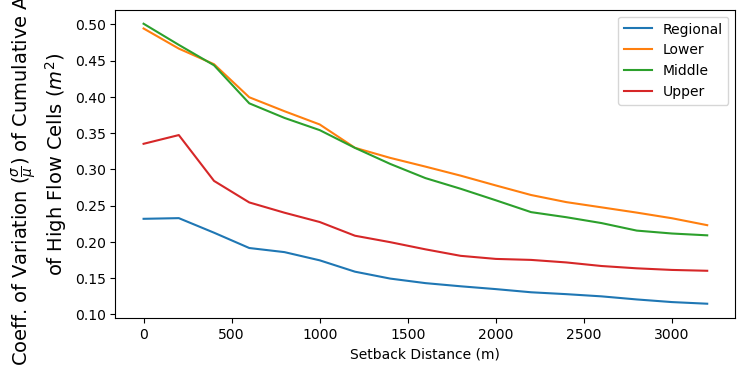

In [52]:
fig,ax = plt.subplots(figsize=(8,4))

# for n in hf_all.index.levels[0]:
#     hf_all.loc[n].std(axis=0).plot(label=n,ax=ax)
# ax.set_ylabel('Standard Deviation of Cumulative Area \nof High Flow Cells Within Setback ($m^2$)')
#hf_all.index.levels[0], reference sites from
for n in site_order:
    (hf_all.loc[n].std(axis=0)/hf_all.loc[n].mean(axis=0)).plot(label=n,ax=ax)
ax.set_ylabel('Coeff. of Variation ($ \\frac{\sigma}{\mu} $) of Cumulative Area \nof High Flow Cells ($m^2$)', size=14)

plt.xlabel('Setback Distance (m)')
plt.legend()
# plt.savefig(fig_dir+'all_sites_coeff_variation_by_distance_'+str(percentile)+'.png',dpi=600)


The coefficient of variation demonstrates that the local scale setbacks have a higher relative standard deviation between
realizations than on a regional scale. The regional scale show a near constant coefficient of variation and the 3 local sites have similar patterns, reducing variability toward larger setback distances.

## Optimal gradient 

Gaussian filters serve to reduce noise and detail in datasets. They can aid in edge detection in imagery because the noise surrounding contours is reduced. In this case, it reduces detail between setback distances but overall allows a clearer picture of the trend.  

I arrived at a sigma of 2 because it is the minimum sigma to ensure a smooth first derivative. Looking back it is making me question whether the gaussian style distribution of results is only because I applied a gaussian filter? The difficulty is we don't want to look at where each individual slope is the maximum but where a region of slopes are the maximum.

The issue with any rolling mean/filter is that the last values in the range can't increase which causes the tail end to encounter less slope after applying the 1st derivative.

In [79]:
# # 1d so the smoothing is specific to each realization
# from scipy.ndimage import gaussian_filter1d
# # smooth across setback distances so the changes in high flow area are less abrupt, makes it easier to find gradients
# # i was using a std deviation of 2
# # smooth = gaussian_filter1d(hf_all,2)
# # smooth = gaussian_filter1d(hf_all,2, mode='mirror')
# smooth = np.copy(hf_all)
# # smooth = hf_all.rolling(3, axis=1, center=True, min_periods=1).mean()
# # smooth = hf_all.rolling(3, axis=1,  win_type='gaussian', min_periods=1).mean(std=2)


# smooth = pd.DataFrame(smooth, index=site_realization_index,columns=np.arange(0,3400,200))

# # smooth
# # plt_hf_cum_area(hf_all.loc['Regional'], percentile,'Regional')
# fig,ax=plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)
# for i,n in enumerate(site_order):
#     ax_n = ax[int(i/2), i % 2]
#     plt_hf_cum_area(smooth.loc[n], percentile,n,ax=ax_n)
# # ax.set_ylabel('Smoothed Cumulative Area \nof High Flow Cells ($m^2$)')
# fig.tight_layout()

In [80]:
# hf_all.loc['Regional'].iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().plot(legend=False,color='lightgray')
# hf_all.loc['Regional'].iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().mean(axis=1).plot(color='black')
# plt.xticks(setbacks[1::2])


In [81]:
# grad1_df.loc['Regional'].iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().plot(legend=False,color='lightgray')
# grad1_df.loc['Regional'].iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().mean(axis=1).plot(color='black')
# hf_all.loc['Regional'].diff(axis=1).iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().plot(legend=False,color='lightgray')
# hf_all.loc['Regional'].diff(axis=1).iloc[:,1:].multiply(1/setbacks[1:], axis=1).transpose().mean(axis=1).plot(color='black')
# plt.xticks(setbacks[1::2])


In [82]:
# n='Regional'
# r = np.arange(1,100).astype(str)
# # can look at maximum of first derivative, or look where second derivative goes from + to -
# grad1_df = pd.DataFrame(np.gradient(smooth)[1], index=site_realization_index, columns = np.arange(0,3400,200))
# # applying gaussian to first derivative directly
# # grad1_df =  gaussian_filter1d(grad1_df,2)
# # grad1_df = pd.DataFrame(grad1_df, index=site_realization_index,columns=np.arange(0,3400,200))

# # plt_hf_cum_area(grad1_df.loc[n].loc[r], percentile, n)

# grad2_df = pd.DataFrame(np.gradient(grad1_df)[1], index=site_realization_index, columns = np.arange(0,3400,200))
# # # grad2_df
# # plt_hf_cum_area(grad2_df.loc[n], percentile, n)
# # find switching points
# # plt.show()
# fig,ax=plt.subplots(3,1,figsize=(6,12))
# smooth.loc[n].loc[r].transpose().plot(legend=False,ax=ax[0], color='lightgray')
# plt.ylabel('High K area smoothed with setbacks')
# ax[0].set_xticks(setbacks[::2])

# grad1_df.loc[n].loc[r].transpose().plot(legend=False,ax=ax[1], color='lightgray')
# plt.ylabel('First derivative of High K area')
# ax[1].set_xticks(setbacks[::2])

# # plt.legend(ncol=5,loc=(1.2,0.2))
# # np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# # + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
# max_df = pd.DataFrame(np.diff(np.sign(grad2_df)), index=site_realization_index,columns = np.arange(200,3400,200))
# max_df = 1*(max_df==-2)

# max_df.loc[n].loc[r].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax[2], color='lightgray')
# plt.ylabel('Realizations with a maximum gradient')
# # fig.tight_layout()


In [45]:
#example of how g
# np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
# grad1_max = np.where(np.diff(np.sign(grad2_df))==-2)

# r = 20
# plt.plot(smooth.values[r,:],label='smooth')

# plt.plot(grad1_df.values[r,:],label='grad1')
# plt.legend()
# print('Grad1 max: ',grad1_df.values[r,:].argmax())
# plt.show()
# plt.plot(grad2_df.values[r,:],label='grad2')

# plt.plot(np.sign(grad2_df).values[r,:],label='sign')
# plt.plot(np.diff(np.sign(grad2_df))[r,:],label='diff')
# plt.legend()

# Plot Smooth, 1st Derivative, Maxima

In [84]:
# max_df_plt = max_df.loc['Regional'].transpose()
# max_df_plt.index

In [83]:
# fig,ax=plt.subplots(figsize=(8,4))
# max_df.loc['Regional'].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax, color='lightgray') 

# # fig.text(-0.01, 0.2,'Number of realizations with a \nmaximum gradient at the setback',rotation=90, fontdict={'size':18})

# # fig.text(-0.01, 0.2,'Maximum gradient count\nby realization',rotation=90, fontdict={'size':14})
# # fig.text(0.4, -.1,'Setback distance (m)',  fontdict={'size':14})
# plt.xlabel('Setback distance (m)')
# plt.ylabel('Maximum gradient count\nby realization')
# # plt.xlim(0,3200)

Text(0.5, 0.01, 'Setback distance (m)')

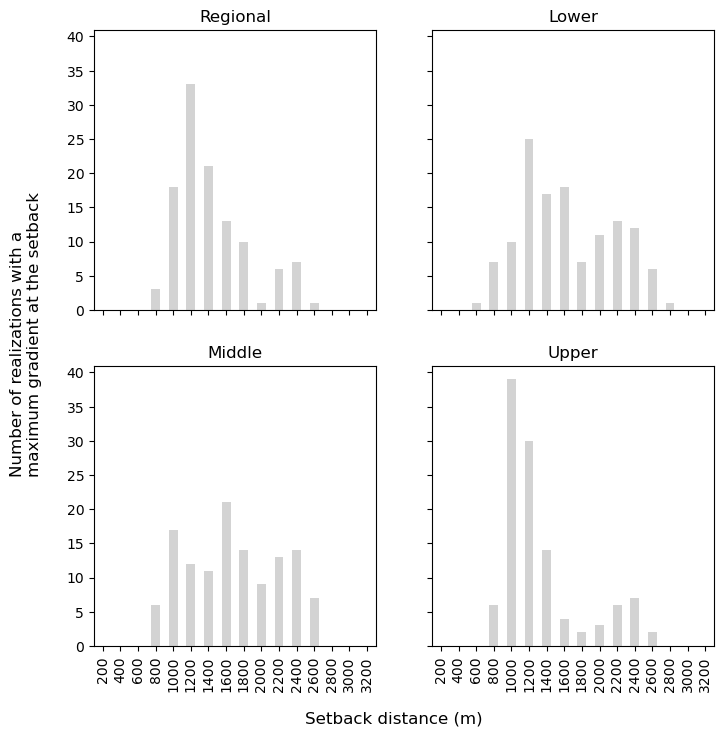

In [84]:
fig,ax=plt.subplots(2,2,figsize=(8,8),sharex=True, sharey=True)
for i,n in enumerate(site_order):
    #.loc[r]
    ax_n = ax[int(i/2), (i % 2)]
    max_df.loc[n].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax_n, color='lightgray') # colormap='gray'
    ax_n.set_title(n)
# fig.text(0.05,0.4,'Number of realizations with a \nmaximum gradient at the setback',rotation=90, fontdict={'size':18})
# fig.text(0.4,0.03,'Setback distance (m)',  fontdict={'size':18})
fig.supylabel('Number of realizations with a \nmaximum gradient at the setback')
fig.supxlabel('Setback distance (m)')

# plt.savefig()
# plt.savefig(fig_dir+'all_sites_max_gradient_by_distance_'+str(percentile)+'.png',dpi=600)


In [148]:
colors = ['lightgray', 'blue']
scale = [0, 1]
cmap=mpl.colors.ListedColormap(colors)
norm=mpl.colors.BoundaryNorm(scale, len(colors))

grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
setbacks = np.arange(0,3200,200)

In [15]:
r=0
folder = '/realization'+ str(r).zfill(3)+'/'
run_ws = model_ws+folder

In [85]:
flow_percentile=6
hf_all_out = np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv', delimiter = '\t')
hf_tot = np.reshape(hf_all_out, (100, 100,230))

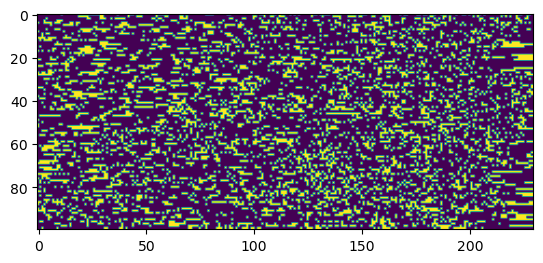

In [86]:
plt.imshow(hf_tot[0])

In [71]:
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')


Text(146.87856357756093, 0.5, 'Northing (m)')

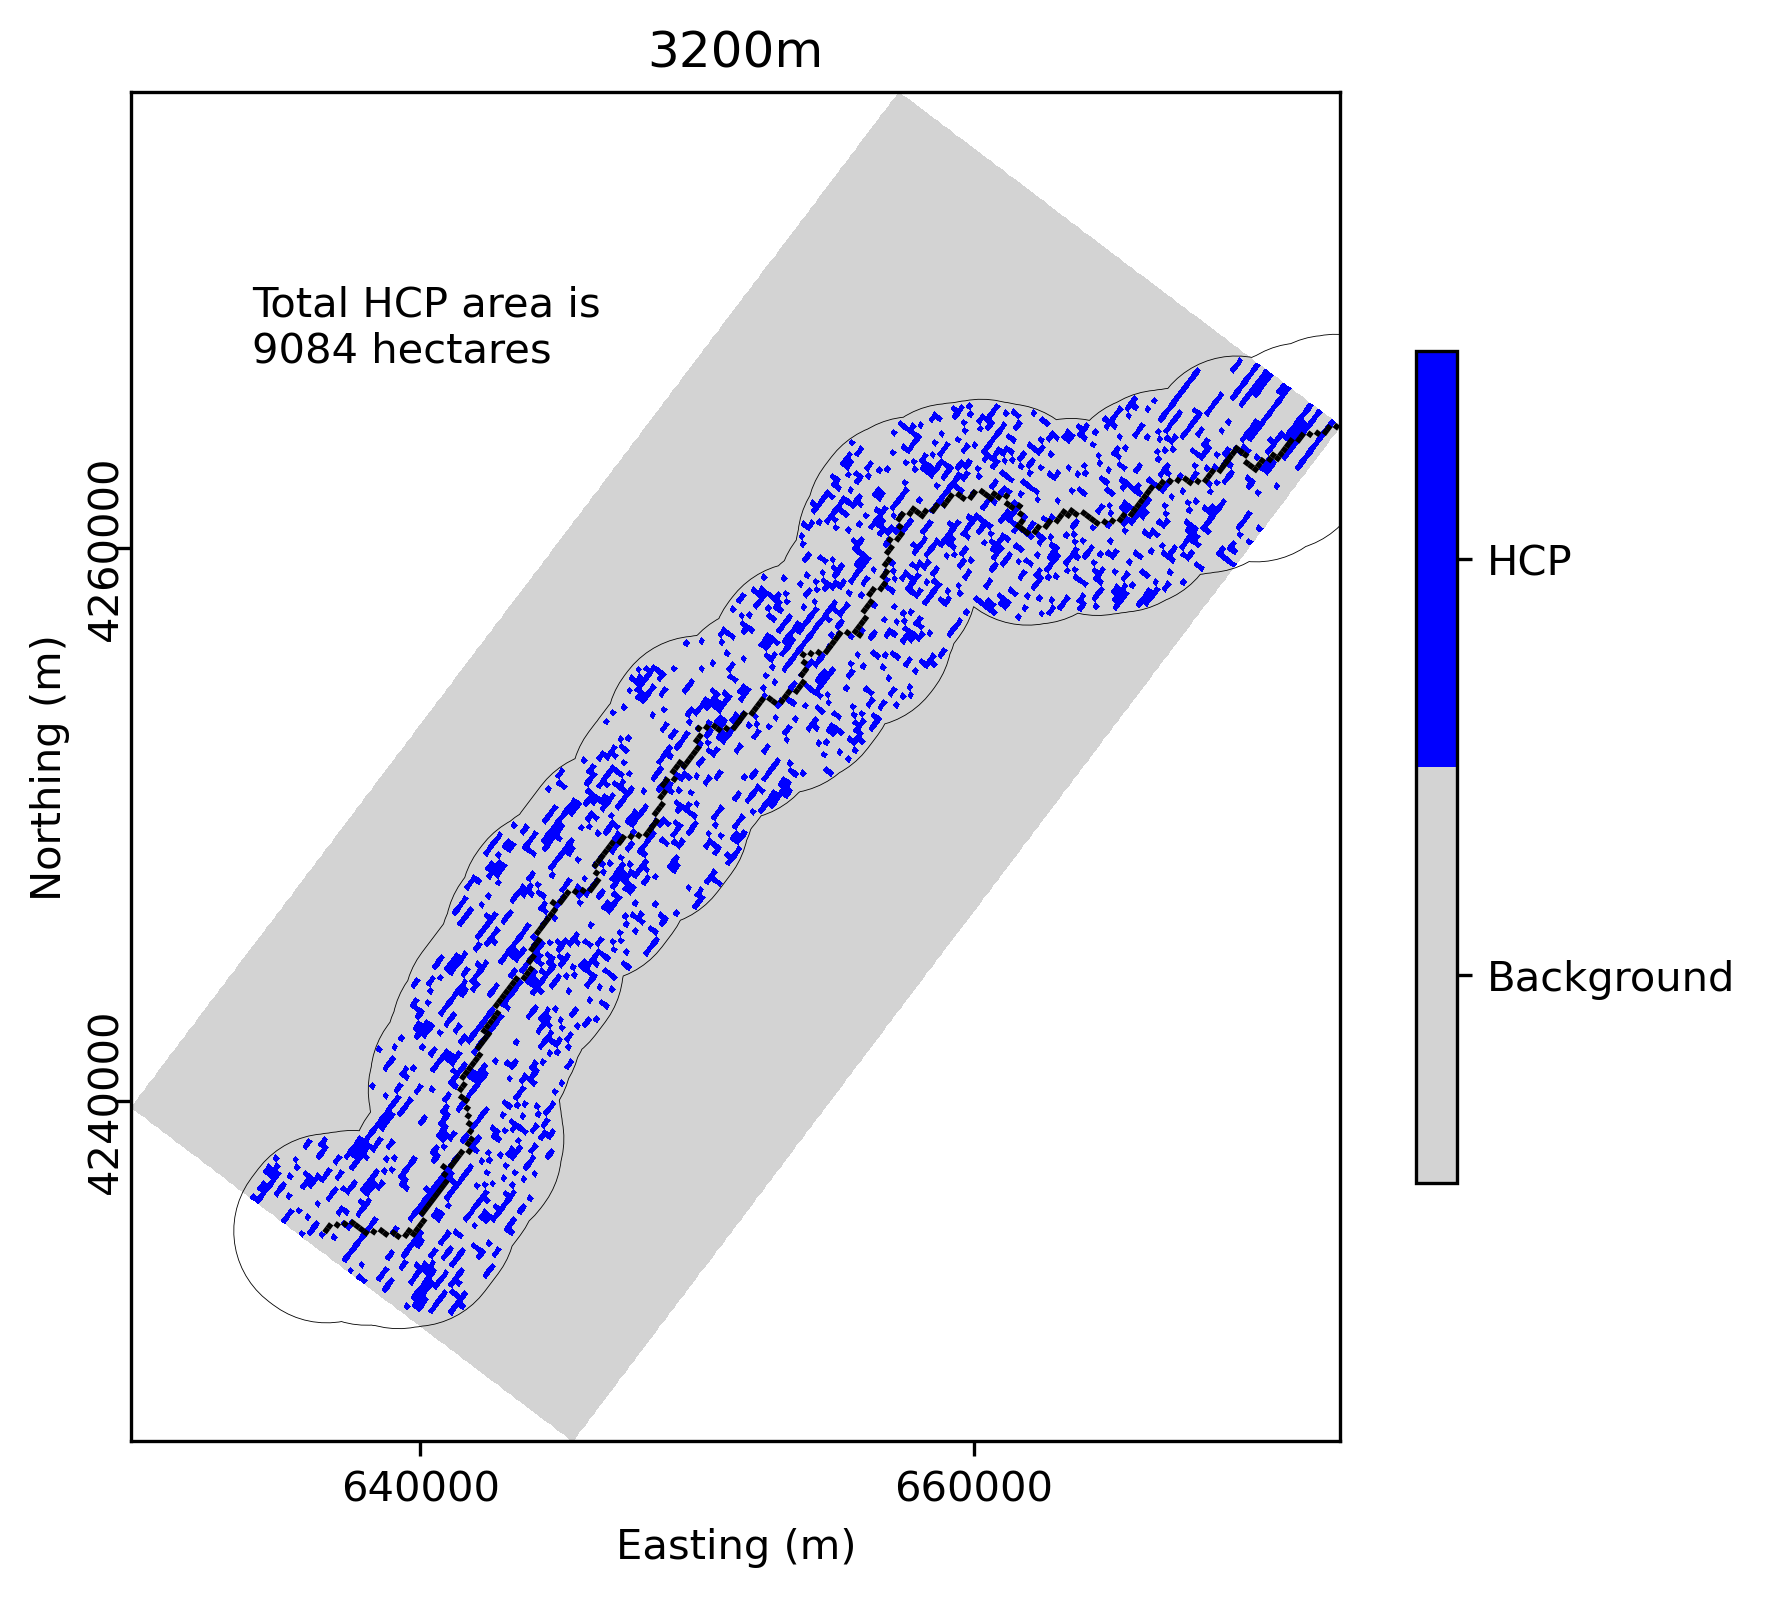

In [106]:

def plt_HCP_setback(qz_lay, str_setback, setback, buf_sfr, label, ax_n):
    temp = np.zeros(qz_lay.shape)
    temp[str_setback.astype('bool')] = qz_lay[str_setback.astype('bool')]
    mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
    im = mapview.plot_array(temp, cmap=cmap)
    ax_n.ticklabel_format(style='plain')
#             im = ax[x,y].imshow(temp,cmap=cmap)
    grid_sfr.plot(ax=ax_n, color='black')
    sfr_union = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_sfr.unary_union], crs='epsg:3310')
    sfr_union.geometry = sfr_union.buffer(setback)
    sfr_union.plot(color="None", edgecolor='black',ax=ax_n, linewidth = 0.2)
    # fix labels, ticks
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)
    rot_ticks =  plt.setp(ax_n.get_yticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    return(im)
fig,ax=plt.subplots(figsize=(6.5,6), dpi=300)
im = plt_HCP_setback(hf_tot[0], str_setbacks[-1], 3200, grid_sfr, label='regional', ax_n=ax)

area = (hf_tot[0]*str_setbacks[-1]).sum()*200*200/1E4
area_label = 'Total HCP area is\n'+str(int(area))+' hectares'
ax.annotate(area_label, xy=(0.1, 0.8), xycoords='axes fraction')

# color bar on all rows, with two discrete labels
cbar=plt.colorbar(mappable = im, ax=ax,  ticks = [0.25,.75], shrink= 0.6)
cbar.ax.set_yticklabels(['Background', 'HCP'])
ax.set_title(str(3200)+'m')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
#   

[Text(1, 0.25, 'HCP'), Text(1, 0.75, 'Background')]

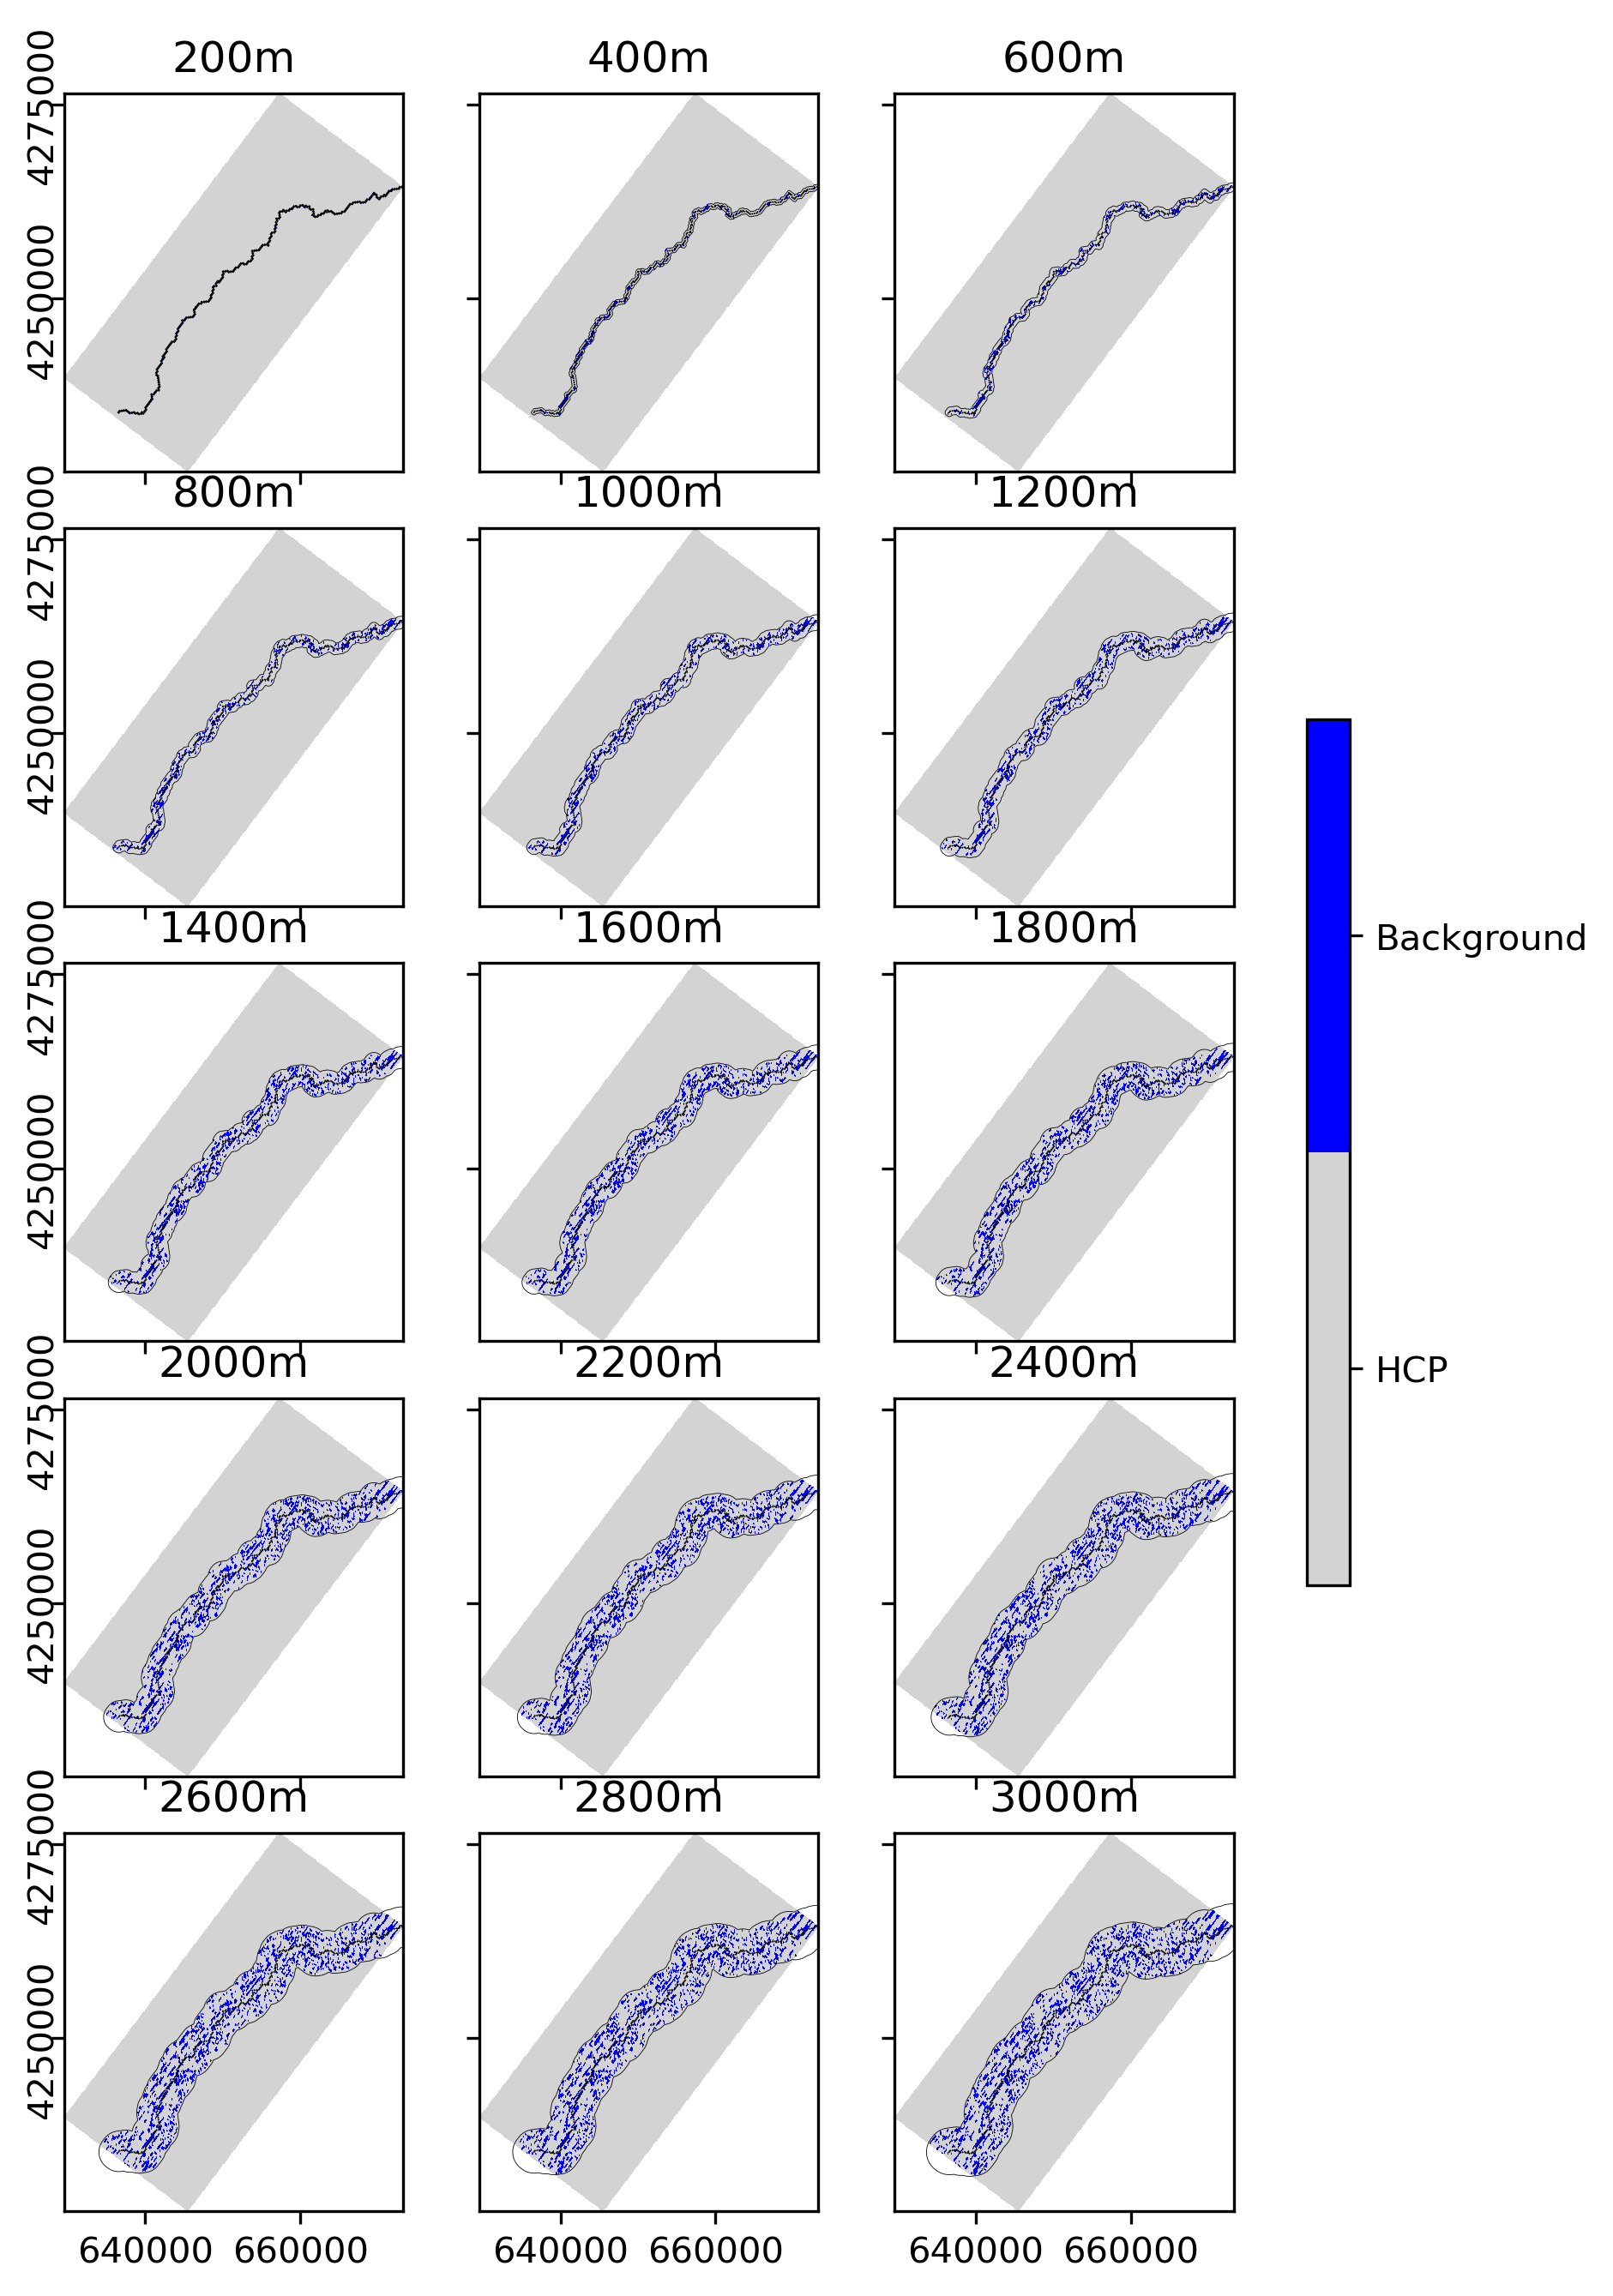

In [85]:
nx = 3
ny = int(len(setbacks)/nx)
fig, ax = plt.subplots(ny,nx,figsize=(6.5,9), sharex=True,sharey=True, dpi=300)
# fig.tight_layout(h_pad=-.1) # space between plots
fig.tight_layout(h_pad=-.7) # space between plots

n=0
for x in np.arange(0,ny):
    for y in np.arange(0,nx):
        ax_n = ax[x,y]
        ax_n.set_title(str(200+200*n)+'m')

        im = plt_HCP_setback(hf_tot[0], str_setbacks[n], setbacks[n], grid_sfr, label='regional', ax_n=ax_n)
        plt.locator_params(axis='y', nbins=1)
        yval = ax_n.get_yticklabels()
#         yval = [yval[0],yval[-1]]
#         yval[1] = 4250000
#         ax_n.set_yticks(yval)
        
        n+=1

# color bar on all rows, with two discrete labels
cbar=plt.colorbar(mappable = im, ax=ax,  ticks = [0.25,.75], shrink= 0.4)
cbar.ax.set_yticklabels(['HCP', 'Background'])

#     plt.savefig(fig_dir+'Comparison of ' + str(flow_percentile)+'th flow facies for '+ label+' setback distances.png',dpi=600)


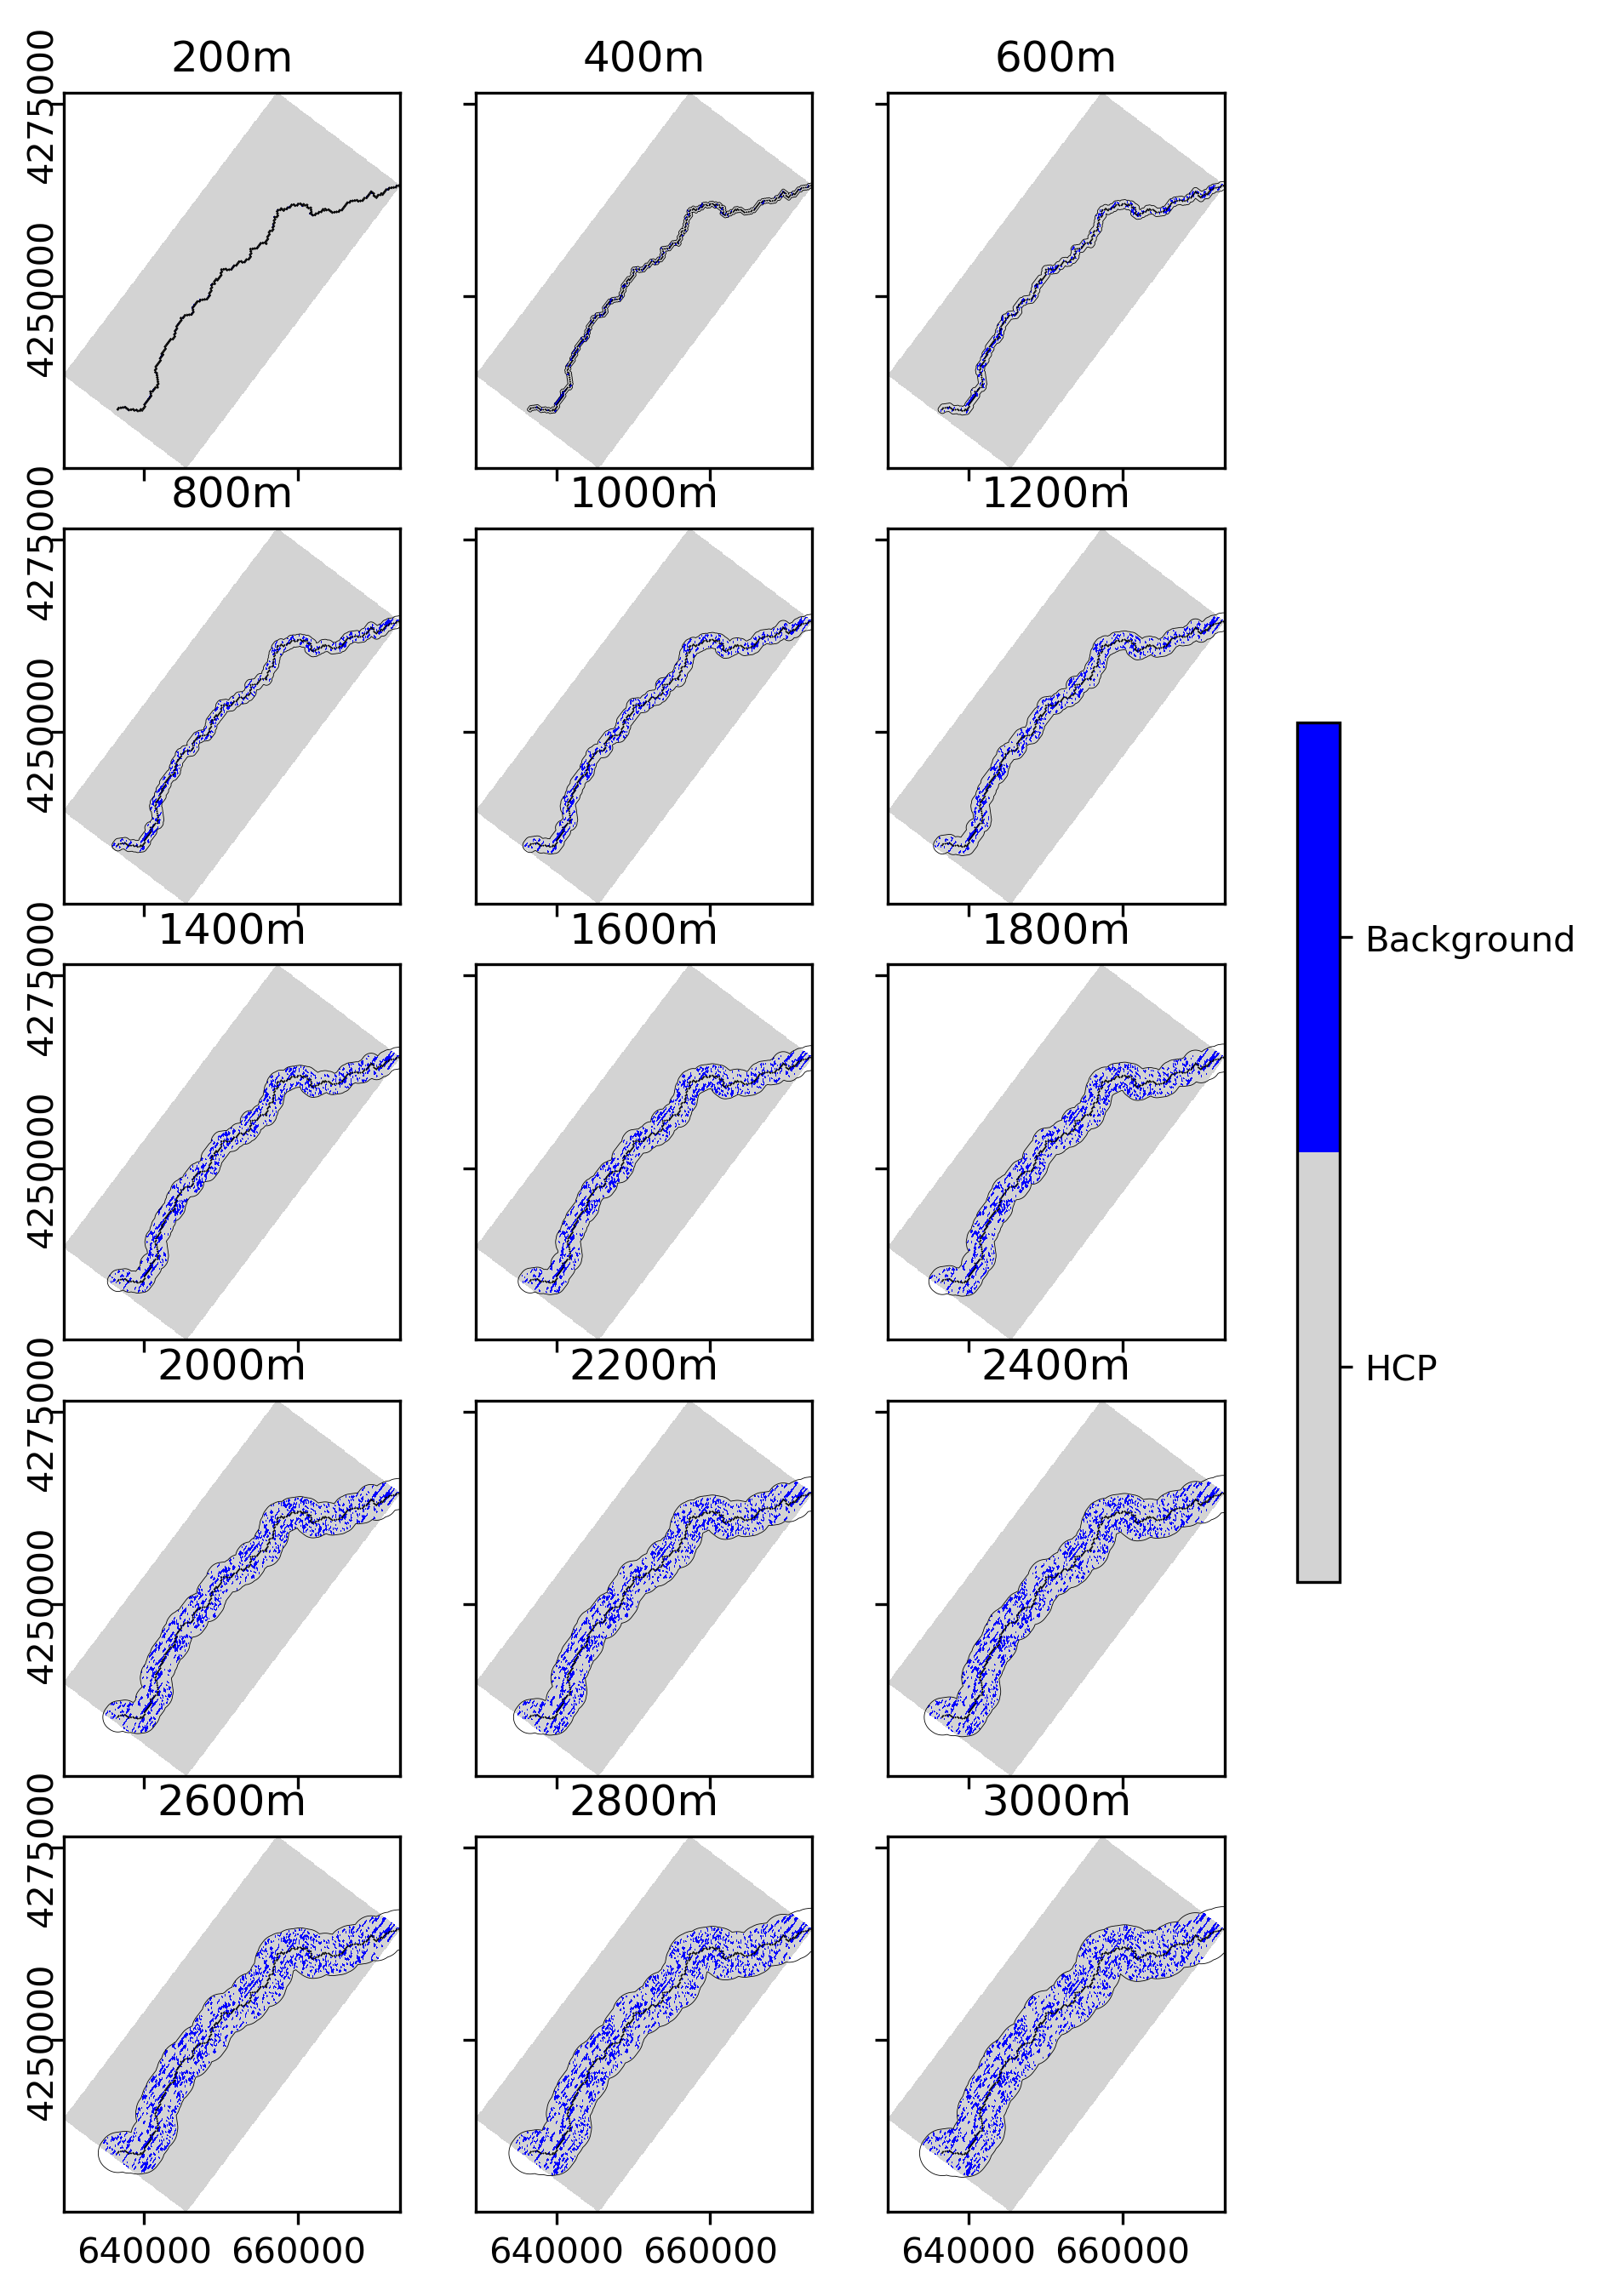

In [31]:

def plt_high_recharge_setback(qz_lay, str_setbacks,label):
    nx = 3
    ny = int(len(setbacks)/nx)
    fig, ax = plt.subplots(ny,nx,figsize=(6.5,9), sharex=True,sharey=True, dpi=300)
    fig.tight_layout(h_pad=-.1) # space between plots
#     cmap = mpl.cm.get_cmap('viridis', 2)    # 2 discrete colors
    buf_sfr = grid_sfr.copy()

    n=0
    for x in np.arange(0,ny):
        for y in np.arange(0,nx):
            ax_n = ax[x,y]
            temp = np.zeros(qz_lay.shape)
            temp[str_setbacks[n,:,:].astype('bool')] = qz_lay[str_setbacks[n,:,:].astype('bool')]
            mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
            im = mapview.plot_array(temp, cmap=cmap)
            ax_n.ticklabel_format(style='plain')
#             im = ax[x,y].imshow(temp,cmap=cmap)
            ax_n.set_title(str(200+200*n)+'m')
            grid_sfr.plot(ax=ax_n, color='black')
            sfr_union = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_sfr.unary_union], crs='epsg:3310')
            sfr_union.geometry = sfr_union.buffer(setbacks[n])
            sfr_union.plot(color="None", edgecolor='black',ax=ax_n, linewidth = 0.2)
            plt.locator_params(axis='y', nbins=2)

            rot_ticks =  plt.setp(ax_n.get_yticklabels(), rotation=90, ha="center", rotation_mode="anchor")
#             sfr_union.plot(color="None", edgecolor='black',ax=ax_n)
            n+=1

    # color bar on all rows, with two discrete labels
    cbar=plt.colorbar(mappable = im, ax=ax,  ticks = [0.25,.75], shrink= 0.4)
    cbar.ax.set_yticklabels(['HCP', 'Background'])

#     plt.savefig(fig_dir+'Comparison of ' + str(flow_percentile)+'th flow facies for '+ label+' setback distances.png',dpi=600)
plt_high_recharge_setback(hf_tot[0], str_setbacks,label='regional')
# plt_high_recharge_setback(q_plt, local_str_setbacks,label='local')

## High K Cell Group Area statistics 

In [38]:
def stats_cell2area(df):
    ''' convert cell count stats to areas'''
    df.Mean *= 200**2
    df.Max *= 200**2
    df.Min *= 200**2
    df.Median *= 200**2
    df.Setback *= 200
#     df = df.set_index('Realization')
    return(df)

cell_stats_all=pd.read_csv(data_dir+'surface_highflow_cells_statistics_regional'+str(percentile)+'.csv')
cell_stats_all = stats_cell2area(cell_stats_all)
cell_stats_all['Location'] = 0
cell_stats_all['Site'] = 'Regional'
# 1:BLodgett, 2:Mahon, 3:Oneto-Denier
# site_dict = {1:'Blodgett',2:'Mahon',3:'Oneto-Denier'}
# cell_stats_all_local = pd.read_csv(data_dir+'surface_highflow_cells_statistics_local'+str(percentile)+'.csv')
# cell_stats_all_local = stats_cell2area(cell_stats_all_local)
# cell_stats_all_local['Site'] = list(site_dict[k] for k in cell_stats_all_local.Location.values)

# cell_stats_all = cell_stats_all.append(cell_stats_all_local)
cell_stats_all = cell_stats_all.set_index(['Site','Realization'])
cell_stats_all['Mean_Num_Grps'] = cell_stats_all.Mean/cell_stats_all.Num_Grps


<AxesSubplot:xlabel='Setback'>

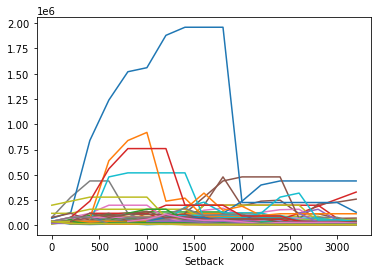

In [32]:
n='Oneto-Denier'
cell_stats_all.loc[n].pivot_table(columns='Realization',values='Mean_Num_Grps',index='Setback').plot(legend=False)

A high number of groups with small mean areas suggests there is no one best place generally to place setbacks, while if the number of groups is small with large mean areas then it is worthwhile creating focused setback.
Compare number of groups to mean area: doesn't seem to be a clear pattern in the mean area divided by the number of groups on a local scale, on a regional scale area divided by number of groups decreases with setback probably because as seback increases there are more small groups but not as many large groups. It could be on a local scale each realiztaion has significantly different outcrops so how it happens isn't regular unless you have geophysical data. This approach can't approximate best locations, only best distances based on cumulated high K area.

Text(0, 0.5, 'Number of High Flow Area Groups')

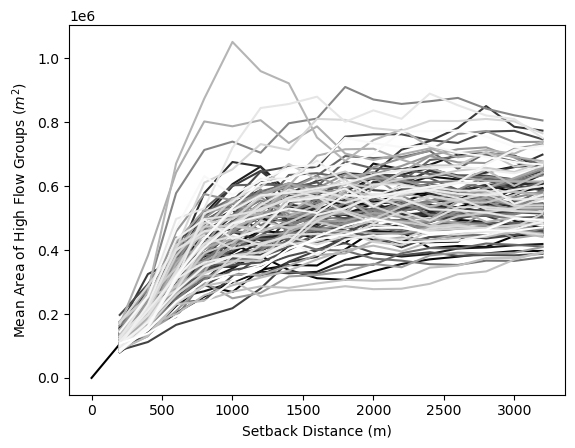

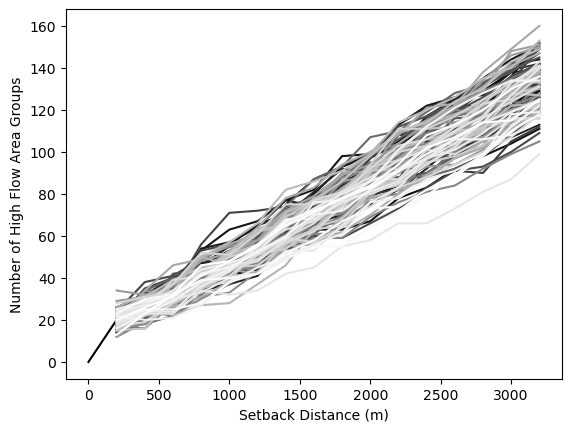

In [39]:
# pd.DataFrame(cell_stats_all_local.loc[:,'Max'])
param='Max'
def plt_cell_stats(df, param):
    df = df.loc[:,[param,'Setback']].pivot_table(values=param, columns='Realization', index='Setback')
    df.plot(colormap='gray', legend=False)
    plt.ylabel(param+' Area of High Flow Groups ($m^2$)')
    plt.xlabel('Setback Distance (m)')
    
    
# plt_cell_stats(cell_stats_all,'Max')
n='Regional'
plt_cell_stats(cell_stats_all.loc[n],'Mean')

plt_cell_stats(cell_stats_all.loc[n],'Num_Grps')
plt.ylabel('Number of High Flow Area Groups')